In [6]:
import torch
import os
import subprocess

repo_root = subprocess.check_output(["git", "rev-parse", "--show-toplevel"]).decode().strip()
os.chdir(repo_root)

print("cwd =", os.getcwd())

from solvers.torch_eit_fem_solver import EIT
from solvers.torch_eit_fem_solver.fem import Mesh, V_h, dtn_map
from solvers.torch_eit_fem_solver.utils import dtn_from_sigma
from torchdiffeq import odeint
import matplotlib.pyplot as plt
import cmocean as cmo
from scipy import io as sio
from tqdm import tqdm
from models.unet import Unet
from collections import OrderedDict
import numpy as np

device = 'cuda:1' 

train_dataset = torch.load('data/eit-circles-dtn-default-128.pt', map_location="cpu")

data_root = 'mesh-data'
mesh_file = 'mesh_128_h05.mat'
mat_fname = os.path.join(data_root, mesh_file)
mat_contents = sio.loadmat(mat_fname)

p = torch.tensor(mat_contents['p'], dtype=torch.float64).to(device)
t = torch.tensor(mat_contents['t']-1, dtype=torch.long).to(device)
vol_idx = torch.tensor(mat_contents['vol_idx'].reshape((-1,))-1, dtype=torch.long).to(device)
bdy_idx = torch.tensor(mat_contents['bdy_idx'].reshape((-1,))-1, dtype=torch.long).to(device)

mesh = Mesh(p, t, bdy_idx, vol_idx)
v_h = V_h(mesh)

dtn_background = dtn_from_sigma(sigma_vec=torch.ones(128, 128), v_h=v_h, mesh=mesh, img_size=128, device=device).cpu()

train_X = train_dataset['train']['dtn_map'].float()
train_X /= dtn_background
train_Y = train_dataset['train']['media'].float()

train_X_min = train_X.min()
train_X_max = train_X.max()
train_Y_min = train_Y.min()
train_Y_max = train_Y.max()

cwd = /home/johnma/flow-inverse


In [7]:
from models.conditional_models import ConditionalConcatUnet

model = ConditionalConcatUnet(unet_ch=32).to(device)

checkpoint = torch.load(
    "saved_runs/circles-eit-concat-unet-flow-default-bg-transform_run1/checkpoints/ckp_31500.tar",
    map_location=device,
)

model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

ConditionalConcatUnet(
  (unet): Unet(
    (input_proj): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (time_proj): Sequential(
      (0): Linear(in_features=32, out_features=128, bias=True)
      (1): SiLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
    (down): ModuleList(
      (0): ModuleList(
        (0-1): 2 x ResBlock(
          (skip_connection): Identity()
          (block1): Sequential(
            (0): GroupNorm(32, 32, eps=1e-05, affine=True)
            (1): SiLU()
            (2): Identity()
            (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (block2): Sequential(
            (0): GroupNorm(32, 32, eps=1e-05, affine=True)
            (1): SiLU()
            (2): Dropout(p=0.1, inplace=False)
            (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (cond_block): ConditioningBlock(
            (proj): Sequential(
            

In [8]:
tubes_data = torch.load('data/eit-tubes-dtn-default-128.pt', map_location='cpu')

test_ood_X = tubes_data['test']['dtn_map'].detach().clone().float()

test_ood_X /= dtn_background

test_ood_X = 2.0 * (test_ood_X - train_X_min) / (train_X_max - train_X_min + 1e-12) - 1.0

if test_ood_X.ndim == 3:
    test_ood_X = test_ood_X.unsqueeze(1)

Sampling: 100%|██████████| 16/16 [00:42<00:00,  2.68s/it]


OOD Relative L2 Error Statistics:
Mean: 0.4665
Std:  0.0573
Min:  0.1907
Max:  0.6549
Median: 0.4666


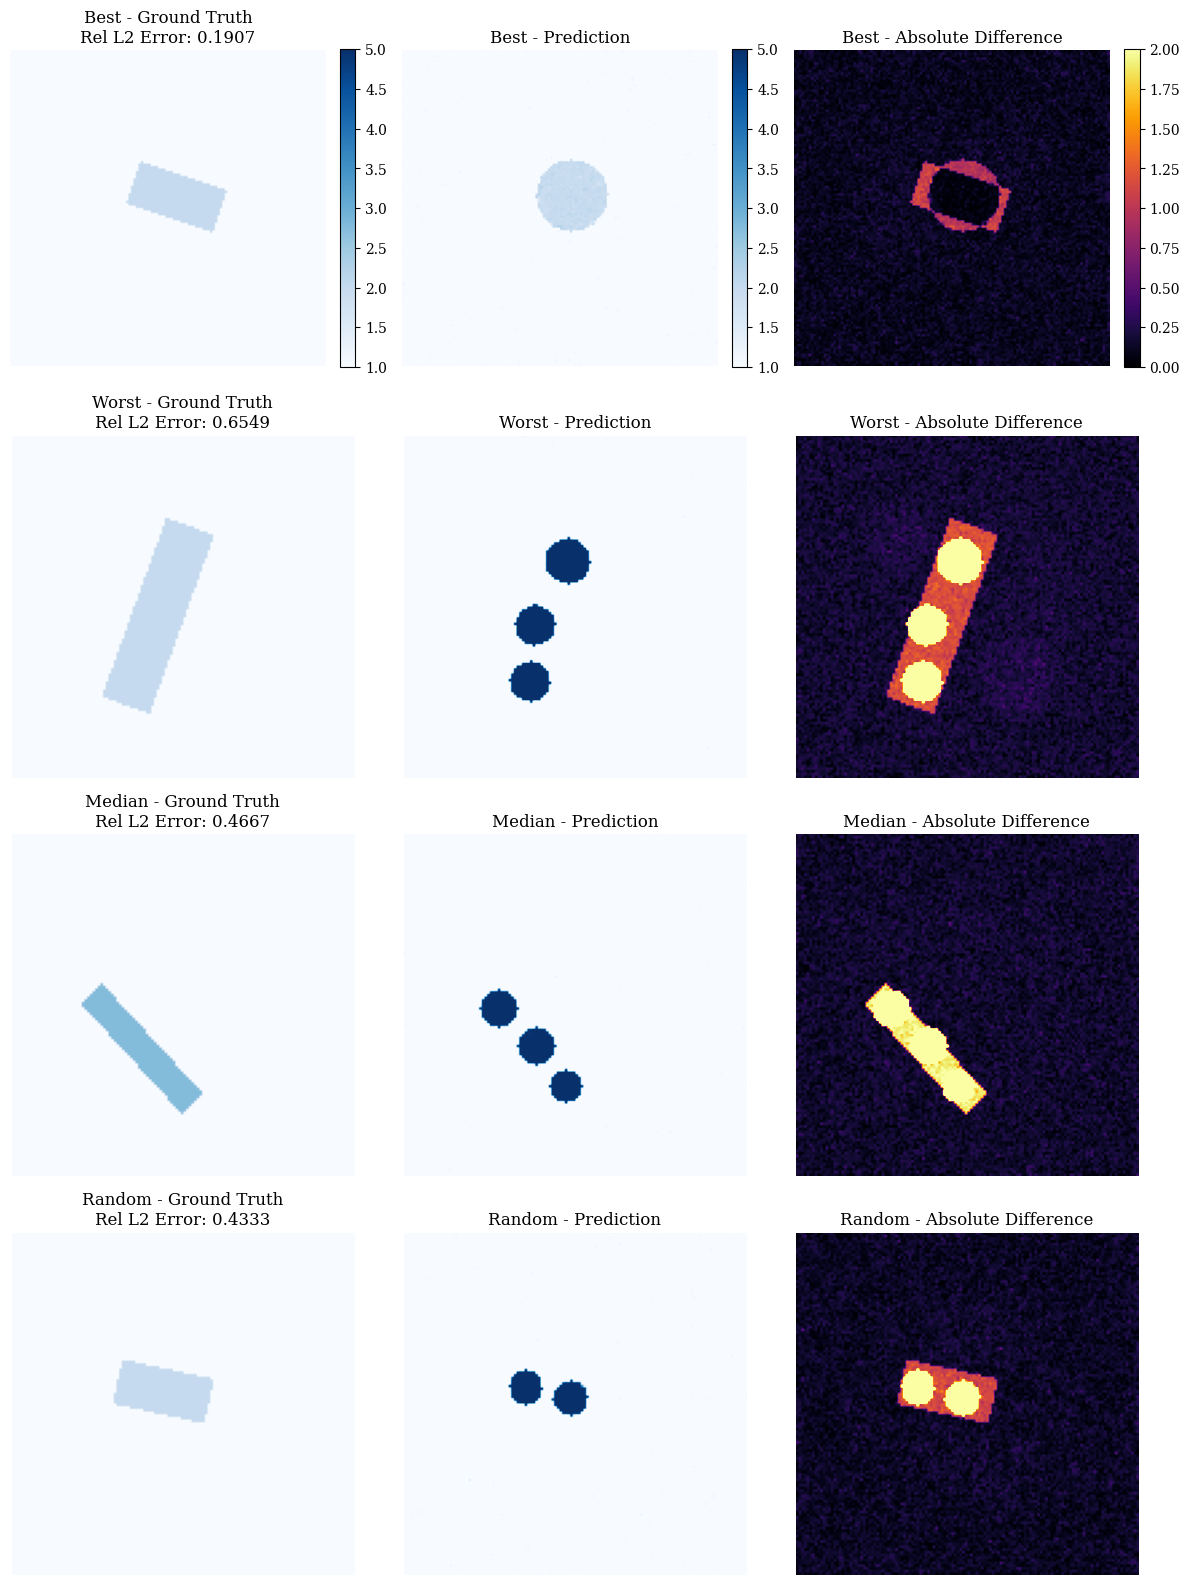

In [14]:
model.eval()
with torch.no_grad():
    test_ood_X = test_ood_X.to(device)

    def v_from_x_pred(z, t, cond):
        guidance_scale = 5.0
        t_batch = t.expand(z.shape[0])
        with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
            v_uncond = model(z, torch.zeros_like(cond), t_batch)
            v_cond = model(z, cond, t_batch)
        return v_uncond + guidance_scale * (v_cond - v_uncond)

    timesteps = torch.linspace(0.0, 1.0, steps=5).to(device)

    bs = 128
    preds_cpu = []

    for start in tqdm(range(0, test_ood_X.shape[0], bs), desc="Sampling"):
        cond = test_ood_X[start:start + bs]
        z0 = torch.randn(cond.shape[0], 1, 128, 128, device=device)

        pred_batch = odeint(
            func=lambda t, x: v_from_x_pred(x, t, cond),
            t=timesteps,
            y0=z0,
            method='rk4',
            atol=1e-5,
            rtol=1e-5,
        )[-1]

        preds_cpu.append(pred_batch.detach().cpu())

        del pred_batch, z0, cond
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    predictions = torch.cat(preds_cpu, dim=0)
    del preds_cpu

    predictions = predictions.squeeze(1)

    predictions = 0.5 * (predictions + 1.0) * (train_Y_max - train_Y_min + 1e-12) + train_Y_min

    rel_l2_errors = []
    for i in range(len(predictions)):
        pred = predictions[i].cpu()
        gt = tubes_data['test']['media'][i].float().cpu()

        error = torch.norm(pred - gt, 2) / torch.norm(gt, 2)
        rel_l2_errors.append(error.item())

    rel_l2_errors = np.array(rel_l2_errors)

    print(f"OOD Relative L2 Error Statistics:")
    print(f"Mean: {rel_l2_errors.mean():.4f}")
    print(f"Std:  {rel_l2_errors.std():.4f}")
    print(f"Min:  {rel_l2_errors.min():.4f}")
    print(f"Max:  {rel_l2_errors.max():.4f}")
    print(f"Median: {np.median(rel_l2_errors):.4f}")

    plt.rcParams["font.family"] = "DejaVu Serif"
    title_font = {"family": "DejaVu Serif", "weight": "bold", "size": 12}

    best_idx = np.argmin(rel_l2_errors)
    worst_idx = np.argmax(rel_l2_errors)
    median_idx = np.argsort(rel_l2_errors)[len(rel_l2_errors) // 2]
    random_idx = np.random.randint(len(rel_l2_errors))

    indices_to_plot = [best_idx, worst_idx, median_idx, random_idx]
    titles = ['Best', 'Worst', 'Median', 'Random']

    fig, axes = plt.subplots(4, 3, figsize=(12, 16))
    for i, (idx, title) in enumerate(zip(indices_to_plot, titles)):
        pred = predictions[idx].cpu().numpy()
        gt = tubes_data['test']['media'][idx].cpu().numpy()
        error = rel_l2_errors[idx]

        im1 = axes[i, 0].imshow(gt, cmap='Blues', vmin=1, vmax=5)
        axes[i, 0].set_title(f'{title} - Ground Truth\nRel L2 Error: {error:.4f}')
        axes[i, 0].axis('off')

        im2 = axes[i, 1].imshow(pred, cmap='Blues', vmin=1, vmax=5)
        axes[i, 1].set_title(f'{title} - Prediction')
        axes[i, 1].axis('off')

        diff = np.abs(pred - gt)
        im3 = axes[i, 2].imshow(diff, cmap='inferno', vmin=0, vmax=2)
        axes[i, 2].set_title(f'{title} - Absolute Difference')
        axes[i, 2].axis('off')

        if i == 0:
            fig.colorbar(im1, ax=axes[0, 0], fraction=0.046, pad=0.04)
            fig.colorbar(im2, ax=axes[0, 1], fraction=0.046, pad=0.04)
            fig.colorbar(im3, ax=axes[0, 2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()